In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch
from torchvision import transforms
import tensorflow as tf
import tensorflow_hub as hub
import torchvision.models as models
import json
from torchvision.models import resnet18
import urllib.request

ModuleNotFoundError: No module named 'torch'

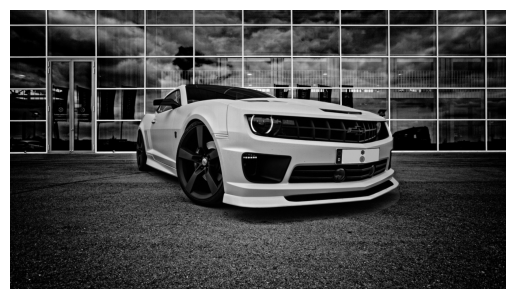

array([[ 3,  8, 11, ..., 15, 20, 22],
       [ 4,  9,  9, ..., 15, 24, 17],
       [ 8,  4,  5, ..., 21, 29, 37],
       ...,
       [ 0,  9, 16, ...,  8, 17, 17],
       [ 7,  4,  3, ..., 12,  9,  2],
       [ 3,  2,  0, ...,  3,  7,  4]], shape=(1440, 2560), dtype=uint8)

In [35]:
# Loading Images
image = cv2.imread("../21568.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()
type(image)
image

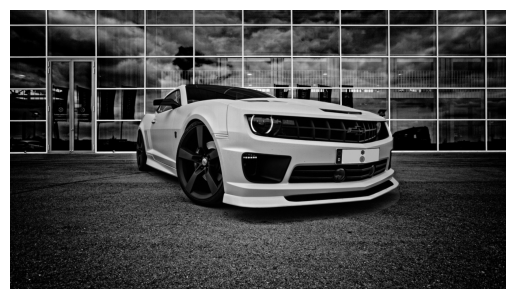

In [ ]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [37]:
# Saving Images
cv2.imwrite('new_image.jpg', image)

True

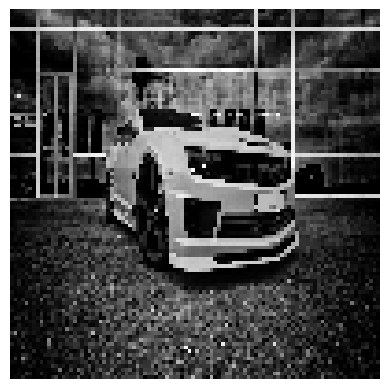

In [38]:
# Resizing Images
image_100x100 = cv2.resize(image, (100,100))
plt.imshow(image_100x100, cmap='gray'), plt.axis("off")
plt.show()

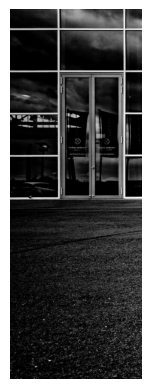

In [39]:
# Cropping Images
image_cropped = image[:,:512]
plt.imshow(image_cropped, cmap="gray"), plt.axis("off")
plt.show()

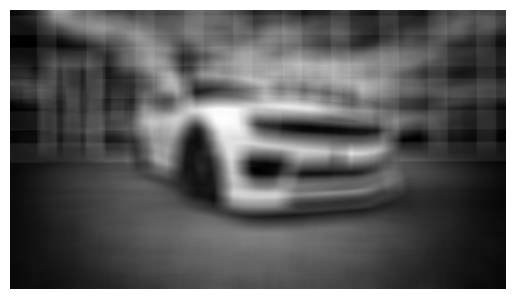

In [40]:
# Blurring Images
image_blurry = cv2.blur(image, (100,100))
plt.imshow(image_blurry, cmap="gray"), plt.axis("off")
plt.show()

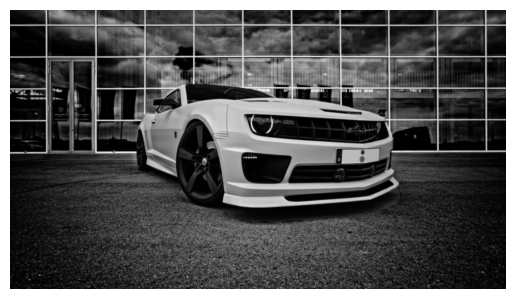

In [41]:
# Image Kernels
kernel = np.ones((5,5)) / 25.0
kernel
image_kernel = cv2.filter2D(image, -1, kernel)
plt.imshow(image_kernel, cmap="gray"), plt.axis("off"), plt.xticks([]), plt.yticks([])
plt.show()

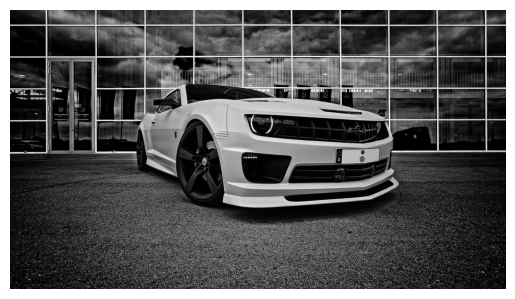

In [42]:
# Sharpening Images
kernel = np.array([[0, -1, 0],[-1, 5,-1],[0, -1, 0]])
image_sharp = cv2.filter2D(image, -1, kernel)
plt.imshow(image_sharp, cmap="gray"), plt.axis("off")
plt.show()

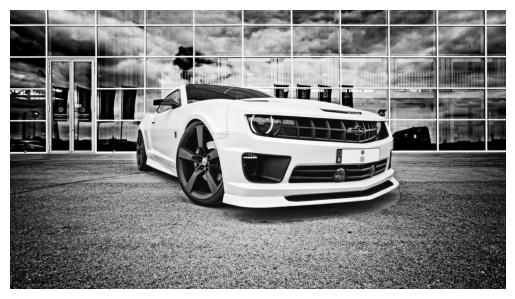

In [43]:
# Enhancing Contrast
image_enhanced = cv2.equalizeHist(image)
plt.imshow(image_enhanced, cmap="gray"), plt.axis("off")
plt.show()

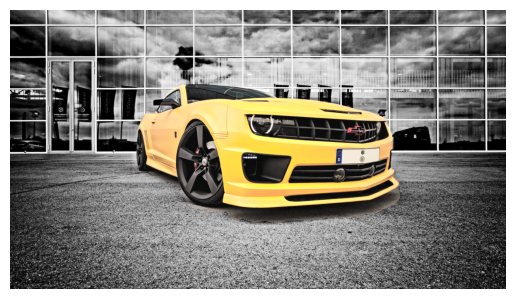

In [44]:
# for Colored image
image_bgr = cv2.imread("../21568.jpg")
image_yuv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YUV)
image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
image_rgb = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
# Show image
plt.imshow(image_rgb), plt.axis("off")
plt.show()

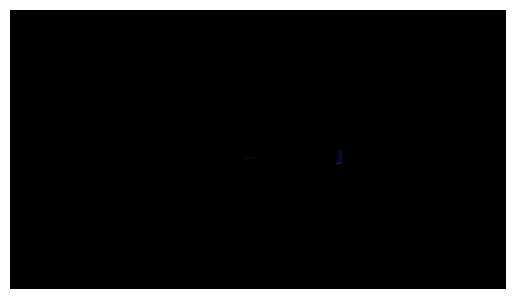

In [45]:
# Isolating Colors of an image
image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
lower_blue = np.array([50,100,50])
upper_blue = np.array([130,255,255])
mask = cv2.inRange(image_hsv, lower_blue, upper_blue)
image_bgr_masked = cv2.bitwise_and(image_bgr, image_bgr, mask=mask)
image_rgb = cv2.cvtColor(image_bgr_masked, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb), plt.axis("off")
plt.show()

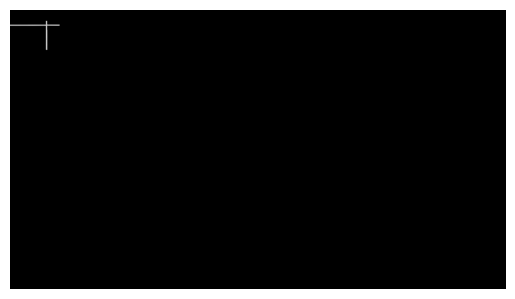

In [46]:
# Removing Backgrounds
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
rectangle = (0, 56, 256, 150)
mask = np.zeros(image_rgb.shape[:2], np.uint8)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)
cv2.grabCut(image_rgb, # Our image
mask, # The Mask
rectangle, # Our rectangle
bgdModel, # Temporary array for background
fgdModel, # Temporary array for background
5, # Number of iterations
cv2.GC_INIT_WITH_RECT) # Initiative using our rectangle
# Create mask where sure and likely backgrounds set to 0, otherwise 1
mask_2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')
image_rgb_nobg = image_rgb * mask_2[:, :, np.newaxis]
# Show image
plt.imshow(image_rgb_nobg), plt.axis("off")
plt.show()

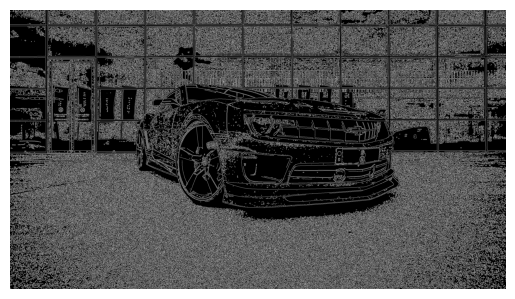

In [48]:
# Detecting edges
median_intensity = np.median(image)
# Set thresholds to be one standard deviation above and below median intensity
lower_threshold = int(max(0, (1.0 - 0.33) * median_intensity))
upper_threshold = int(min(255, (1.0 + 0.33) * median_intensity))
image_canny = cv2.Canny(image, lower_threshold, upper_threshold)
# Show image
plt.imshow(image_canny, cmap="gray"), plt.axis("off")
plt.show()

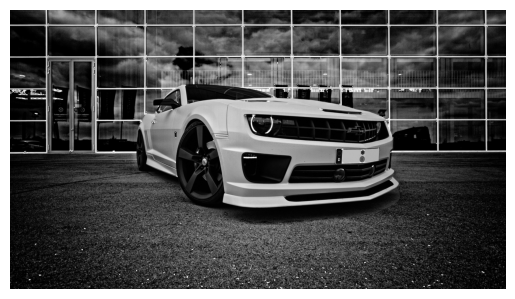

In [49]:
# Detecting corners
image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
image_gray = np.float32(image_gray)
# Set corner detector parameters
block_size = 2
aperture = 29
free_parameter = 0.04
# Detect corners
detector_responses = cv2.cornerHarris(image_gray,block_size,aperture,free_parameter)
# Large corner markers
detector_responses = cv2.dilate(detector_responses, None)
# Only keep detector responses greater than threshold, mark as white
threshold = 0.02
image_bgr[detector_responses >
threshold *
detector_responses.max()] = [255,255,255]
# Convert to grayscale
image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
# Show image
plt.imshow(image_gray, cmap="gray"), plt.axis("off")
plt.show()

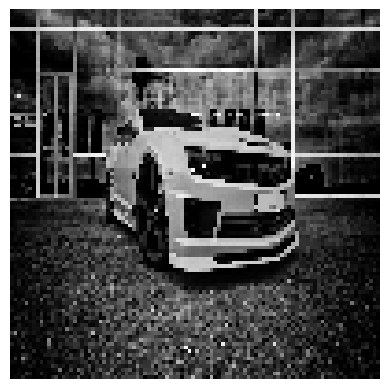

In [51]:
# Creating features for machine learning
image_100x100.flatten()
plt.imshow(image_100x100, cmap="gray"), plt.axis("off")
plt.show()

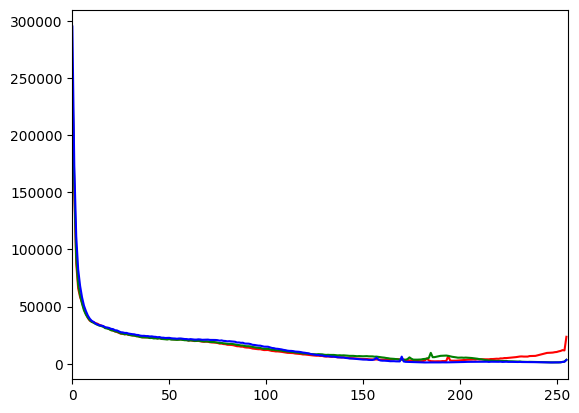

array([248014., 150261.,  87917.], dtype=float32)

In [53]:
# Encoding Color Histograms as Features
features = []
colors = ('r', 'g', 'b')
for i, channel in enumerate(colors):
    histogram = cv2.calcHist([image_rgb],[i], None, [256], [0,256])
    features.extend(histogram)
    plt.plot(histogram, color = channel)
    plt.xlim([0,256])
plt.show()
observation = np.array(features).flatten()
observation[0:3]

In [54]:
# Using Pretrained Embeddings as Features
convert_tensor = transforms.ToTensor()
pytorch_image = convert_tensor(np.array(image_rgb))
# Load the pretrained model
model = models.resnet18(pretrained=True)
# Select the specific layer of the model we want output from
layer = model._modules.get('avgpool')
# Set model to evaluation mode
model.eval()
# Infer the embedding with the no_grad option
with torch.no_grad():
    embedding = model(pytorch_image.unsqueeze(0))
print(embedding.shape)

NameError: name 'transforms' is not defined

In [ ]:
tf_image = tf.image.convert_image_dtype([image_rgb], tf.float32)
# Create the model and get embeddings using the inception V1 model
embedding_model = hub.KerasLayer(
"https://tfhub.dev/google/imagenet/inception_v1/feature_vector/5"
)
embeddings = embedding_model(tf_image)
# Print the shape of the embedding
print(embeddings.shape)

In [ ]:
# Detecting Objects with Opencv
face_cascade = cv2.CascadeClassifier()
face_cascade.load(
    cv2.samples.findFile("models/haarcascade_frontalface_default.xml")
)
image_bgr = cv2.imread("images/kyle_pic.jpg", cv2.IMREAD_COLOR)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
faces = face_cascade.detectMultiScale(image_rgb)
for (x,y,w,h) in faces:
    cv2.rectangle(image_rgb, (x, y),(x + h, y + w),(0, 255, 0), 5)
plt.subplot(1, 1, 1)
plt.imshow(image_rgb)
plt.show()

In [ ]:
# Classifying Images with Pytorch
with urllib.request.urlopen("https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/"):
    imagenet_class_index = json.load(url)
model = resnet18(pretrained=True)
convert_tensor = transforms.ToTensor()
pytorch_image = convert_tensor(np.array(image_rgb))
# Set model to evaluation mode
model.eval()
prediction = model(pytorch_image.unsqueeze(0))
# Get the index of the highest predicted probability
_, index = torch.max(prediction, 1)
# Convert that to a percentage value
percentage = torch.nn.functional.softmax(prediction, dim=1)[0] * 100
# Print the name of the item at the index along with the percent confidence
print(imagenet_class_index[str(index.tolist()[0])][1],
percentage[index.tolist()[0]].item())